<a href="https://colab.research.google.com/github/vantuan5644/MachineLearningCourse/blob/master/AuthorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Gutenberg - Author Classification 

- **Objective**: Use NLP and supervised learning and unsupervised learning techniques to classify text-authors

- **Data description**: [Project Gutenberg](https://www.gutenberg.org/)
  - Data is crawled using alternative-API (raw text)
  - 1000 random authors
  - In English language

- **Outline**
  - Text cleaning with SpaCy
  - Convert text to numerical vector using tf-idf and Bag-of-words
  - Word2vec using Gensim
  - Using ML classification methods (Naive Bayes, Decision Tree, Random Forest)
  - Using RNN (LSTM)
  - Using LSA, LDA and NMFA for **topic modeling**
  - Analysis and conclusions

## NLTK Gutenberg Corpus

In [14]:
import keras 
import tensorflow
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [0]:
from nltk.corpus import gutenberg

In [0]:
len(gutenberg.fileids())

18

In [0]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

# Main features of SpaCy:
1. Tokenization: Segmenting text into words, punctuations marks
2. Part-of-speech Tagging: Assign word types (verb, noun)
3. Dependency Parsing: Assign syntactic dependency labels (subject or object)
4. Sentence Boundary Detection: Segmenting individual sentences
5. Named Entity Recognition: Labelling named "real-world" objects (persons, companies, locations)
6. Entity Linking: Disambiguating textual entities to unique identifiers in a Knowledge Base
7. Similarity: Comparing words, text spans, documents
8. Text Classification: Assigning categories or labels to a whole document
9. Rule-based Matching: Finding sequences of tokens based on their texts and linguistic annotations
10. Training: Updating and improving a statistical model's prediction
11. Serialization: Saving objects to files or byte strings

## Some terms in NLP
1. Text: The base form of the word
2. POS: The simple part-of-speech tag
3. Tag: The detailed part-of-speech tag
4. Dep: Syntactic dependency (the relation between tokens)
5. Shape: The word shape -  capitalization, punctuation, digits
6. is alpha: Is the token an alpha character?
7. is stop: is the token part of a stop list

In [0]:
# Load default model
import spacy
nlp = spacy.load("en_core_web_sm")

In [0]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Apple Apple PROPN NNP nsubj Xxxxx True False
is be VERB VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
U.K. U.K. PROPN NNP compound X.X. False False
startup startup NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


![Vocab, hashes and lexemes](https://spacy.io/vocab_stringstore-1d1c9ccd7a1cf4d168bfe4ca791e6eed.svg)

In [0]:
spacy.explain("NNP")

'noun, proper singular'

In [0]:
spacy.explain("VBZ")

'verb, 3rd person singular present'

#### Visualizing the dependency parse

In [0]:
from spacy import displacy

In [0]:
displacy.render(doc, style="ent", jupyter=True)

In [0]:
displacy.render(doc, style="dep", jupyter=True)

# Extract statistics description about the corpus

In [0]:
gutenberg_corpus = {}
for fileid in gutenberg.fileids():
  gutenberg_corpus[fileid] = {}
  gutenberg_corpus[fileid]['num_vocab'] = len(set([w.lower() for w in gutenberg.words(fileid)]))
  gutenberg_corpus[fileid]['nof_chars_per_word'] = len(gutenberg.raw(fileid)) / len(gutenberg.words(fileid))
  gutenberg_corpus[fileid]['nof_words_per_sentence'] = len(gutenberg.words(fileid)) / len(gutenberg.sents(fileid))
  gutenberg_corpus[fileid]['nof_times_per_word'] = len(gutenberg.words(fileid)) / num_vocab

In [0]:
gutenberg_corpus_df = pd.DataFrame(gutenberg_corpus).T

In [0]:
gutenberg_corpus_df

,num_vocab,nof_chars_per_word,nof_words_per_sentence,nof_times_per_word
austen-emma.txt,7344.0,4.609909,24.822884,15.453501
austen-persuasion.txt,5835.0,4.749794,26.199893,7.883954
austen-sense.txt,6403.0,4.753786,28.320864,11.369740
bible-kjv.txt,12767.0,4.286882,33.573199,81.163990
blake-poems.txt,1535.0,4.567034,19.073059,0.670896
bryant-stories.txt,3940.0,4.489300,19.407265,4.462175
burgess-busterbrown.txt,1559.0,4.464642,17.991461,1.522888
carroll-alice.txt,2636.0,4.233216,20.029360,2.739319
chesterton-ball.txt,8335.0,4.716174,20.296296,7.789592
chesterton-brown.txt,7794.0,4.724783,22.612454,6.911580


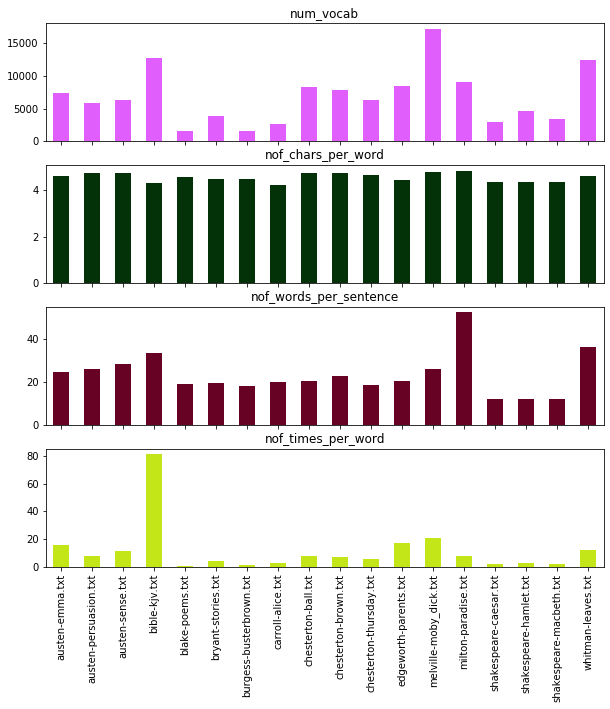

In [0]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(gutenberg_corpus_df.columns), ncols=1)
for i, metric in enumerate(gutenberg_corpus_df.columns):
    gutenberg_corpus_df[metric].plot(ax=axes[i], kind='bar', sharex=True, sharey=False, figsize=(10, 10), title=gutenberg_corpus_df.columns[i], color=np.random.rand(3))
    # plt.xlabel(dim)
    
plt.show()


## Gutenberg alt-API

### Install dependencies

In [0]:
!git clone https://github.com/c-w/Gutenberg.git


Cloning into 'Gutenberg'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2441 (delta 11), reused 16 (delta 5), pack-reused 2416
Receiving objects: 100% (2441/2441), 5.99 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (1565/1565), done.


In [0]:
!sudo apt-get install libdb++-dev
!export BERKELEYDB_DIR=/usr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libdb5.3++ libdb5.3++-dev libdb5.3-dev
Suggested packages:
  db5.3-doc
The following NEW packages will be installed:
  libdb++-dev libdb5.3++ libdb5.3++-dev libdb5.3-dev
0 upgraded, 4 newly installed, 0 to remove and 7 not upgraded.
Need to get 2,245 kB of archives.
After this operation, 8,395 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdb5.3++ amd64 5.3.28-13.1ubuntu1.1 [703 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdb5.3-dev amd64 5.3.28-13.1ubuntu1.1 [762 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdb5.3++-dev amd64 5.3.28-13.1ubuntu1.1 [778 kB]
Get:4 http://archive.ubuntu.co

In [0]:
%cd Gutenberg/
!pip3 install .

/content/Gutenberg
Processing /content/Gutenberg
  Using cached https://files.pythonhosted.org/packages/b0/1d/d7c60a451a255fca655fe37eb3f6e3b3daa7d33fc87eeec0d8631d501e76/SPARQLWrapper-1.8.4-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e9/fc/ebfbd4de236b493f9ece156f816c21df0ae87ccc22604c5f9b664efef1b9/bsddb3-6.2.6.tar.gz
     |████████████████████████████████| 348kB 44.5MB/s 
     |████████████████████████████████| 1.1MB 66.5MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
     |████████████████████████████████| 471kB 59.9MB/s 
  Created wheel for Gutenberg: filename=Gutenberg-0.8.0-cp36-none-any.whl size=26370 sha256=204591df8fde80448f5602bab08e536708d875ad3038974a38f4ac6658ea6aff
  Stored in directory: /tmp/pip-ephem-wheel-cache-hle2hsj2/wheels/a6/bb/7e/2beb48e3bec826e0278109e548ddd807fe6972d2c4626bdd4f
  Created wheel for bsddb3: filename=bsddb3-6.2.6-cp36-cp36m-linux_x86_64.whl size=298292 sha256=e17f7f0ca7f9b7dbb47ecd0ab86aa2c6d012fa9e3c0517a9

### Populate the cache

In [0]:
# from gutenberg.acquire import get_metadata_cache
# cache = get_metadata_cache()
# cache.populate()

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Get the downloaded data

In [0]:
# data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/gutenberg_sample_authors.csv')
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/gutenberg_authors_big.csv')

In [0]:
data

,key,language,author,title,subject,encoding,text
0,10060,en,"Huxley, Thomas Henry",Discourses: Biological & Geological Essays,Geology Biology Q,us-ascii,Richard Prairie and PG Distributed Proofreader...
1,10078,en,"Johnson, Douglas Wilson",Plain Words from America: A Letter to a German...,"World War, 1914-1918 -- Public opinion D501",us-ascii,Distributed Proofreaders\n\n\n\nPLAIN WORDS FR...
2,10096,en,Euripides,The Trojan women of Euripides,"Helen, of Troy, Queen of Sparta -- Drama Hecub...",iso-8859-1,THE TROJAN WOMEN OF EURIPIDES\n\n\n\nTRANSLATE...
3,10097,en,"Carpenter, Edward",The Healing of Nations and the Hidden Sources ...,"World War, 1914-1918 D501",utf-8,THE HEALING OF NATIONS AND THE HIDDEN SOURCES ...
4,10213,en,"Gregory, Jackson",The Everlasting Whisper,PS Western stories California -- Fiction,utf-8,THE EVERLASTING WHISPER\n\n_A Tale of the Cali...
...,...,...,...,...,...,...,...
2424,9869,en,"Musset, Alfred de",The Confession of a Child of the Century,Historical fiction PQ French fiction,iso-8859-1,THE CONFESSION OF\n\n A C...
2425,9966,en,"Perkins, Lucy Fitch",The Spartan Twins,Twins -- Juvenile fiction PZ Greece -- History...,us-ascii,THE SPARTAN TWINS\n\n ...
2426,9968,en,"Oxley, James Macdonald","The Young Woodsman; Or, Life in the Forests of...",Hunting -- Fiction Adventure stories Outdoor l...,iso-8859-1,Online Distributed Proofreading Team\n\n\n\n\n...
2427,9982,en,"Child, Lydia Maria",Philothea: A Grecian Romance,PS Greece -- Fiction,iso-8859-1,PHILOTHEA:\n\nA Grecian Romance.\n\nBY L. MARI...


In [0]:
data.author.nunique()

968

In [0]:
data.shape[0]

2429

In [0]:
text = data.iloc[2428].text

### Divide into Training-set, Dev-set, Test-set


In [0]:
from spacy.lang.en import English # updated
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated


In [0]:
def get_sentences(raw_text):
  max_length = min(1000000, len(raw_text))
  raw_text = raw_text[:max_length]
  doc = nlp(raw_text)
  sentences = [sent.string.strip() for sent in doc.sents]
  sentences = sentences[5:]
  return sentences

In [0]:
train_df = data.copy()

In [0]:
sentences = train_df.apply(lambda x: get_sentences(x['text']), axis=1)

In [0]:
# sentences.to_csv('sentences.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [0]:
training_set = []
dev_set = []
test_set = []

train_size = 0.8
dev_size = 0.1
test_size = 0.1 

for i in sentences.index:
  label = train_df.iloc[i].author

  text = sentences[i]

  np.random.shuffle(text)

  train_data = text[:round(len(text) * train_size)]

  dev_data = text[round(len(text) * train_size):round(len(text) * (train_size + dev_size))]
                    
  test_data = text[round(len(text) * (train_size + dev_size)):]

  training_set.append({'label': label, 'data': train_data})
  dev_set.append({'label': label, 'data': val_data})
  test_set.append({'label': label, 'data': test_data})



In [0]:
# from google.colab import files
# files.download('/content/test_set.csv') 


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Data preprocessing

In [0]:
training_set = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/training_set_sampling.csv')
dev_set = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/dev_set_sampling.csv')
test_set = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/test_set_sampling.csv')

#### Dataset sampling

In [0]:
import textwrap

In [0]:
def dataset_sampling(df):
  result_df = []
  for index in df.index:
    label = df.iloc[index]['label']
    text_wrap = textwrap.wrap(df.iloc[index]['data'], width=10000)
    for text_small in text_wrap:
      result_df.append({'label': label,
                    'string': text_small})
  return pd.DataFrame(result_df)

In [0]:
training_set = dataset_sampling(training_set)

In [0]:
dev_set = dataset_sampling(dev_set)

In [0]:
test_set = dataset_sampling(test_set)

#### Remove stopwords

In [0]:
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string

In [0]:
# A custom stoplist
STOPLIST = set(list(STOP_WORDS) + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve", "--", "\n"]

In [0]:
print(STOPLIST)
print(SYMBOLS)

{'namely', 'anything', 'doing', 'detail', 'nine', 'describe', 'upon', 'with', 'see', 'somehow', 'twelve', 'without', 'whereupon', 'under', 'who', 'latter', 'herself', 'whom', 'mostly', 'sometimes', 'wherein', 'my', 'may', 'either', 'among', 'say', 'they', 'have', 'can', 'co', 'always', 'per', 'becomes', 'amount', 'except', 'itself', 'myself', 'perhaps', "'m", 'sometime', 'further', 'ten', 'done', 'yet', 'onto', 'eight', 'therefore', 'empty', 'ltd', 'almost', 'until', 'within', 'down', 'no', 'fifty', 'even', 'first', 'mill', 'that', 'elsewhere', 'neither', 'there', 'after', 'cannot', 'find', 'former', 'give', 'con', 'go', 'anywhere', 'now', 'all', 'been', 'more', 'out', 'anyone', 'across', 'her', 'his', '’m', 'forty', 'again', 'latterly', 'beyond', 'did', 'most', 'last', 'where', 'too', 'whereby', 'regarding', 'whoever', 'became', 'nobody', 'formerly', 'seeming', 'make', 'eg', 'become', 'hence', 'so', '’s', 'someone', "'ve", 'serious', 'our', 'via', 'such', 'seemed', 'another', 'cant', 

In [0]:
import spacy
nlp = spacy.load("en", disable=["parser", "tagger", "ner"])
#  turn off named entity recognition, tagging and dependency parsing...

## Custom Text Processor

In [0]:
def cleanup_text(docs, logging=False):
  texts = []
  counter = 1
  for doc in docs:
    if not isinstance(doc, str):
      doc = str(doc)

    max_length = min(1000000, len(doc))
    doc = doc[:max_length]
    doc = doc.strip().replace("\n", " ").replace("--", " ")

    # print(doc)
    # if counter > 10:
      # break

    if counter % 100 == 0 and logging:
      print("Processed %d out of %d documents." % (counter, len(docs)))
    counter += 1

    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in STOPLIST and tok not in SYMBOLS]
    tokens = ' '.join(tokens)

    texts.append(tokens)
  return

In [0]:
import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator

nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        # normalized_text = self._normalize(text)
        text = str(text)

        doc = nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in SYMBOLS]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc]).strip()



# Vectorization

In [16]:
print(training_set.shape)
training_set.head()

(70083, 2)


,label,string
0,"Huxley, Thomas Henry",['How did these isolated patches of a northern...
1,"Huxley, Thomas Henry","dismissed,\nwithout further consideration, as ..."
2,"Huxley, Thomas Henry","the surface like the others, but in this\ncase..."
3,"Huxley, Thomas Henry","doctrine of evolution, especially in regard to..."
4,"Huxley, Thomas Henry","a very fine and impalpable powder, or a very p..."


In [17]:
print(dev_set.shape)
dev_set.head()

(9843, 2)


,label,string
0,"Huxley, Thomas Henry","['Dr. Stirling, has not taken the trouble to r..."
1,"Huxley, Thomas Henry",Turpin and Schwann resolved the living body in...
2,"Huxley, Thomas Henry","succession of changes which, upon the\nwhole, ..."
3,"Huxley, Thomas Henry","of view.', 'Few will venture to affirm that th..."
4,"Huxley, Thomas Henry","sarcode stuck against one side, the\nremainder..."


In [18]:
print(test_set.shape)
test_set.head()

(9825, 2)


,label,string
0,"Huxley, Thomas Henry","['Thus he writes:--""I do not pretend, as he [M..."
1,"Huxley, Thomas Henry",face facts and to learn the exact\nquantity an...
2,"Huxley, Thomas Henry","that, in some animals,\ndevastating epidemics ..."
3,"Huxley, Thomas Henry",from the multitude of other things\nwhich go b...
4,"Huxley, Thomas Henry","and\ncarbon, and accumulate nitrogen.', 'There..."


In [0]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline


In [0]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


In [0]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    text = text.replace("\n", " ").replace("--", " ")
    return text.strip().lower()

### Bag-of-words Vectorization

In [0]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

### Tf-idf


In [0]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, max_features=10000)


### SVM

In [0]:
from sklearn.svm import SVC


In [0]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [0]:
param_grid = {'kernel': ['linear', 'rbf'],
              'C': [0.1, 1, 10]}

clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)


In [0]:
training_set.to_csv('training_set_big.csv', index=False)

In [0]:
X_train = training_set['string']
y_train = training_set['label']

In [0]:
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])
# model generation
pipe.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [0]:
print(clf.best_estimator_)


In [0]:
X_test, y_test = test_set['string'], test_set['label']
y_pred = clf.predict(X_test)


In [0]:
print(classification_report(y_test, y_pred))


## Gradient Boosting with GridSearchCV


In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [0]:
param_grid = {'n_estimators': [100, 200, 500, 1000],
              'min_samples_leaf': [1, 2, 5],
              }
# param_grid = {}
clf = GridSearchCV(GradientBoostingClassifier(), param_grid)
# clf = GradientBoostingClassifier()

#### Use dev-set to hyperparameters-tuning

In [0]:
X_train = dev_set['string']
y_train = dev_set['label']

In [0]:
# Create pipeline using Bag of Words

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', clf)], 
                memory='./',
                verbose=True)

# model generation
pipe.fit(X_train, y_train)


[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.3s


In [0]:
print(clf.best_estimator_)


In [0]:
X_test, y_test = test_set['string'], test_set['label']
y_pred = pipe.predict(X_test)


In [0]:
print(classification_report(y_test, y_pred))


In [0]:
classification_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
classification_report.to_csv('classification_report_gradient_boosting.csv', index=False)

from google.colab import files
files.download('classification_report_gradient_boosting.csv')

classification_report

## RandomForest


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
import itertools


In [0]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [0]:
def get_minibatch(doc_iter, size, pos_class='acq'):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [('{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)

In [0]:
param_grid = {'n_estimators':[100, 200, 500],
              'n_jobs': [-1]}

param_grid = {}
clf = GridSearchCV(RandomForestClassifier(), param_grid)


In [0]:
X_train = training_set['string']
y_train = training_set['label']

In [0]:
# Create pipeline using Bag of Words

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)],
                memory='./',
                verbose=True)

# model generation
pipe.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.

[Pipeline] ........ (step 3 of 3) Processing classifier, total= 7.0min


Pipeline(memory='./',
         steps=[('cleaner', <__main__.predictors object at 0x7fedffeea2e8>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=10000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,...
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                       

In [0]:
print(clf.best_estimator_)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [0]:
X_test, y_test = test_set['string'], test_set['label']
y_pred = pipe.predict(X_test)


In [0]:
classification_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
classification_report.to_csv('classification_report_random_forest.csv', index=False)

from google.colab import files
files.download('classification_report_random_forest.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
classification_report

,precision,recall,f1-score,support
"Aaberg, Jens Christian",0.400000,0.500000,0.444444,4.000000
"Abbott, Lemuel Abijah",0.300000,0.600000,0.400000,5.000000
"Acland, Charles",0.142857,0.500000,0.222222,4.000000
"Adams, Charles Francis",0.250000,0.500000,0.333333,10.000000
"Adams, Henry Gardiner",0.000000,0.000000,0.000000,2.000000
...,...,...,...,...
"Zacks, Robert",0.000000,0.000000,0.000000,2.000000
"Zderad, Loretta T. Paterson, Josephine G.",1.000000,1.000000,1.000000,4.000000
accuracy,0.660967,0.660967,0.660967,0.660967
macro avg,0.568255,0.447274,0.467059,9825.000000


## Decision Tree


In [0]:
from sklearn import tree


In [0]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [0]:
# param_grid = {'learning_rate': [0.1, 0.25, 0.5, 0.75]}
param_grid = {}
clf = GridSearchCV(tree.DecisionTreeClassifier(), param_grid)

In [0]:
X_train = training_set['string']
y_train = training_set['label']


In [0]:
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', clf)])
# model generation
pipe.fit(X_train, y_train)


In [0]:
print(clf.best_estimator_)


In [0]:
X_test, y_test = test_set['string'], test_set['label']
y_pred = clf.predict(X_test)


In [0]:
print(classification_report(y_test, y_pred))


# Gensim Word2Vec

In [0]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


In [0]:
import multiprocessing

from gensim.models import Word2Vec


INFO - 15:02:40: 'pattern' package not found; tag filters are not available for English


#### Text cleaning, remove non-alphabetic characters

In [0]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [0]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in training_set['string'])


In [0]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=2048, n_threads=-1)]


Put the results in a DF to remove missing values and duplicates

In [0]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(69873, 1)

In [0]:
df_clean

,clean
0,' isolate patch northern population ndeep pl...
1,dismiss nwithout consideration monstrous unwar...
2,surface like ncase melting iceberg precipitati...
3,doctrine evolution especially regard land anim...
4,fine impalpable powder pure nwell rectify spir...
...,...
70078,npolitical machinery ' ' educational influence...
70079,apparent ' ' let receive spirit nis offer ' ' ...
70080,adaptation consider hi correct helpful nbecaus...
70081,tendency separation nand segregation pronounce...


#### Init Word2Vec Model

In [0]:
multiprocessing.cpu_count() # Count the number of cores in a computer


4

In [0]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=4)


- **min_count**: ignore all words with total absolute frequency lower than this

- **window**: The maximum distance between the current and predicted word within a sentence

- **size**: The dimensionality of feature vectors

- **sample**: The threshold for configuring which higher-frequency wors are randomly downsampled

- **alpha**: The initial learning rate

- **min_alpha**: Learning rate will be linearly dropped to min_alpha as training progresses

- **negative**: If negative > 0, negative sampling will be used

- **workers**: The numer of threads to train the model

In [0]:
from gensim.models.phrases import Phrases, Phraser


The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task

In [0]:
sent = [row.split() for row in df_clean['clean']]


Biagrams:

Use Gensim Phrases package to automatically detect common pharases from a list of sentences

In [0]:
phrases = Phrases(sent, min_count=30, progress_per=10000)


INFO - 16:32:10: collecting all words and their counts
INFO - 16:32:10: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:32:25: PROGRESS: at sentence #10000, processed 9403733 words and 4335301 word types
INFO - 16:32:41: PROGRESS: at sentence #20000, processed 18854530 words and 7528656 word types
INFO - 16:32:56: PROGRESS: at sentence #30000, processed 28402256 words and 10262113 word types
INFO - 16:33:13: PROGRESS: at sentence #40000, processed 38013235 words and 12896304 word types
INFO - 16:33:29: PROGRESS: at sentence #50000, processed 47552150 words and 15258884 word types
INFO - 16:33:45: PROGRESS: at sentence #60000, processed 57124520 words and 17489041 word types
INFO - 16:34:01: collected 19580951 word types from a corpus of 66543217 words (unigram + bigrams) and 69873 sentences
INFO - 16:34:01: using 19580951 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [0]:
bigram = Phraser(phrases)



INFO - 16:34:01: source_vocab length 19580951
INFO - 16:36:59: Phraser built with 15920 phrasegrams


In [0]:
sentences = bigram[sent]


#### Building the Vocabolary Table

W2V requires us to build the vocabulary table (simply using all the unique words)

Here the **min_count** and **sample** hyperparameters have a great influence over the performance of a model

In [0]:
w2v_model.build_vocab(sentences, progress_per=10000)


INFO - 16:37:00: collecting all words and their counts
INFO - 16:37:00: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:37:21: PROGRESS: at sentence #10000, processed 9145615 words, keeping 162327 word types
INFO - 16:37:43: PROGRESS: at sentence #20000, processed 18316098 words, keeping 233391 word types
INFO - 16:38:06: PROGRESS: at sentence #30000, processed 27588241 words, keeping 283400 word types
INFO - 16:38:28: PROGRESS: at sentence #40000, processed 36900073 words, keeping 341014 word types
INFO - 16:38:51: PROGRESS: at sentence #50000, processed 46142323 words, keeping 390055 word types
INFO - 16:39:13: PROGRESS: at sentence #60000, processed 55430093 words, keeping 437973 word types
INFO - 16:39:35: collected 480571 word types from a corpus of 64576898 raw words and 69873 sentences
INFO - 16:39:35: Loading a fresh vocabulary
INFO - 16:39:37: effective_min_count=20 retains 85522 unique words (17% of original 480571, drops 395049)
INFO - 16:39:37: e

#### Model training

- **total_examples**: Count of the sentences

- **epochs**: Nof iteration over the corpus

In [0]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)


In [0]:
w2v_model.init_sims(replace=True)


INFO - 18:40:50: precomputing L2-norms of word weight vectors


In [0]:
w2v_model.wv.most_similar(positive=["love"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('nlove', 0.711361289024353),
 ('lover', 0.6574570536613464),
 ('heart', 0.6459301710128784),
 ('soul', 0.6380823254585266),
 ('pity', 0.6357269287109375),
 ('adore', 0.6257433295249939),
 ('loving', 0.613831102848053),
 ('god', 0.6018456220626831),
 ('joy', 0.5969570875167847),
 ('hate', 0.5955204963684082)]

In [0]:
w2v_model.wv.similarity('peace', 'war')


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.4140251

In [0]:
w2v_model.save("word2vec.model")

INFO - 18:45:32: saving Word2Vec object under word2vec.model, separately None
INFO - 18:45:32: storing np array 'vectors' to word2vec.model.wv.vectors.npy
INFO - 18:45:32: not storing attribute vectors_norm
INFO - 18:45:32: storing np array 'syn1neg' to word2vec.model.trainables.syn1neg.npy
INFO - 18:45:32: not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 18:45:32: saved word2vec.model


In [0]:
from google.colab import files
files.download("word2vec.model")

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [0]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


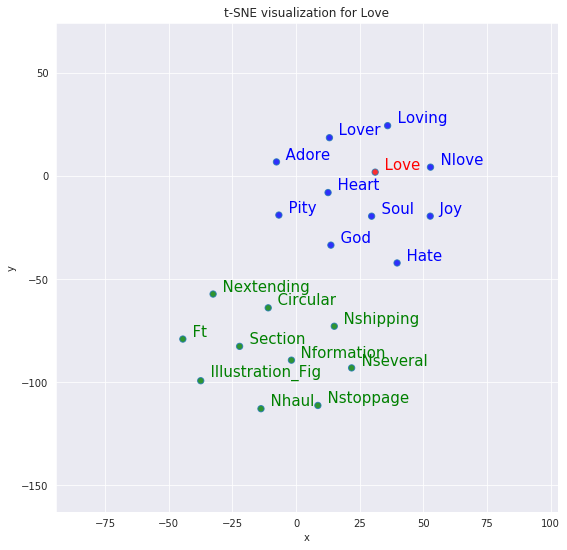

In [0]:
tsnescatterplot(w2v_model, 'love', [i[0] for i in w2v_model.wv.most_similar(negative=["love"])])


# LSTM

In [0]:
pretrained_weights = w2v_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['model', 'network', 'train', 'learn']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) 
                           for similar, dist in w2v_model.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))

def word2idx(word):
  return w2v_model.wv.vocab[word].index
def idx2word(idx):
  return w2v_model.wv.index2word[idx]

Result embedding shape: (85522, 300)
Checking similar words:
  model -> nmodel (0.60), type (0.53), zm_model (0.48), zam (0.47), xzm (0.47), example (0.46), symbolic_model (0.46), zm (0.46)
  network -> nnetwork (0.52), mesh (0.43), web (0.42), thread (0.41), ramification (0.40), intricate (0.39), waterway (0.37), ramify (0.37)
  train -> ntrain (0.63), car (0.54), passenger_train (0.52), freight_train (0.49), train_stop (0.49), cab (0.48), carriage (0.48), station (0.47)
  learn -> teach (0.72), know (0.64), understand (0.61), acquaint (0.58), tell (0.55), learn_lesson (0.53), instruct (0.52), read (0.51)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, 
                    weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size))
model.add(Dense(units=vocab_size))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Topic Modeling

In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


In [0]:
import pandas as pd

In [0]:
training_set = pd.read_csv('/training_set.csv')

In [0]:
# Convert to list
data = training_set['data'].to_list()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub('\n+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



In [0]:
# Tokenize words and Clean-up text

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['how', 'did', 'these', 'isolated', 'patches', 'of', 'northern', 'population', 'get', 'into', 'these', 'ndeep', 'places', 'modern', 'chemistry', 'the', 'birth', 'of', 'the', 'latter', 'half', 'of', 'the', 'eighteenth', 'century', 'ngrew', 'apace', 'and', 'soon', 'found', 'herself', 'face', 'to', 'face', 'with', 'the', 'great', 'problems', 'nwhich', 'biology', 'had', 'vainly', 'tried', 'to', 'attack', 'without', 'her', 'help', 'footnote', 'to', 'working', 'men', 'on', 'the', 'causes', 'of', 'the', 'phenomena', 'of', 'norganic', 'nature_', 'iii', 'rerum', 'natura_', 'lib', 'the', 'passage', 'of', 'air', 'through', 'red', 'hot', 'glass', 'tubes', 'or', 'through', 'nstrong', 'sulphuric', 'acid', 'does', 'not', 'alter', 'the', 'proportion', 'of', 'its', 'oxygen', 'while', 'nit', 'must', 'needs', 'arrest', 'or', 'destroy', 'any', 'organic', 'matter', 'which', 'may', 'be', 'ncontained', 'in', 'the', 'air', 'as', 'to', 'the', 'if', 'we', 'may', 'trust', 'the', 'evidence', 'which', 'nseems', '

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['how', 'did', 'these', 'isolated', 'patches', 'of', 'northern', 'population', 'get', 'into', 'these', 'ndeep', 'places', 'modern', 'chemistry', 'the', 'birth', 'of', 'the', 'latter', 'half', 'of', 'the', 'eighteenth_century', 'ngrew', 'apace', 'and', 'soon', 'found', 'herself', 'face', 'to', 'face', 'with', 'the', 'great', 'problems', 'nwhich', 'biology', 'had', 'vainly', 'tried', 'to', 'attack', 'without', 'her', 'help', 'footnote', 'to', 'working', 'men', 'on', 'the', 'causes', 'of', 'the', 'phenomena', 'of', 'norganic', 'nature_', 'iii', 'rerum_natura_', 'lib', 'the', 'passage', 'of', 'air', 'through', 'red', 'hot', 'glass', 'tubes', 'or', 'through', 'nstrong', 'sulphuric_acid', 'does', 'not', 'alter', 'the', 'proportion', 'of', 'its', 'oxygen', 'while', 'nit', 'must', 'needs', 'arrest', 'or', 'destroy', 'any', 'organic', 'matter', 'which', 'may', 'be', 'ncontained', 'in', 'the', 'air', 'as', 'to', 'the', 'if', 'we', 'may', 'trust', 'the', 'evidence', 'which', 'nseems', 'to', 'be',

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['isolate', 'patch', 'northern', 'population', 'get', 'ndeep', 'place', 'modern', 'chemistry', 'birth', 'latter', 'half', 'eighteenth_century', 'ngrew', 'apace', 'soon', 'find', 'face', 'face', 'great', 'problem', 'nwhich', 'biology', 'vainly', 'try', 'attack', 'help', 'footnote', 'work', 'man', 'cause', 'nature', 'lib', 'passage', 'air', 'red', 'hot', 'glass', 'tube', 'nstrong', 'sulphuric_acid', 'alter', 'proportion', 'nit', 'must', 'needs', 'arrest', 'destroy', 'organic', 'matter', 'may', 'may', 'trust', 'evidence', 'nseem', 'afford', 'scanty', 'remain', 'hypsiprymnoid', 'form', 'nexiste', 'tria', 'carnivorous', 'ankylose', 'understand', 'nearth', 'rotation', 'be', 'undergo', 'retardation', 'coal', 'nfossil', 'forest', 'present', 'many', 'evidence', 'subaerial', 'condition', 'highly_creditable', 'ingenuity', 'ancestor', 'npeculiar', 'virtue', 'make', 'nglad', 'heart', 'man', 'seem', 'know', 'remotest', 'period', 'nof', 'record', 'teutonic', 'cousin', 'call', 'process', 'seem', 'ret

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]



In [0]:
# View
print(corpus[:1])


[[(0, 1), (1, 2), (2, 3), (3, 1), (4, 20), (5, 1), (6, 1), (7, 8), (8, 1), (9, 1), (10, 8), (11, 6), (12, 3), (13, 4), (14, 7), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 4), (21, 13), (22, 5), (23, 1), (24, 3), (25, 8), (26, 1), (27, 5), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 7), (35, 1), (36, 19), (37, 4), (38, 22), (39, 18), (40, 14), (41, 1), (42, 3), (43, 3), (44, 2), (45, 1), (46, 1), (47, 1), (48, 2), (49, 2), (50, 4), (51, 1), (52, 11), (53, 2), (54, 2), (55, 6), (56, 13), (57, 10), (58, 2), (59, 13), (60, 1), (61, 9), (62, 4), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 14), (70, 4), (71, 5), (72, 12), (73, 5), (74, 1), (75, 2), (76, 1), (77, 2), (78, 3), (79, 1), (80, 2), (81, 1), (82, 4), (83, 1), (84, 2), (85, 27), (86, 2), (87, 1), (88, 6), (89, 4), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 3), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 9), (104, 1), (105, 3), (106, 6), (107, 3), (108, 1), (109,

 ## LDA

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [0]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.000*"ccviii" + 0.000*"cccxxvi" + 0.000*"finegraine" + 0.000*"diatomaceæ" '
  '+ 0.000*"cxxxiv" + 0.000*"cxlvi" + 0.000*"ccxv" + 0.000*"menstrua" + '
  '0.000*"cclxxii" + 0.000*"cccxlix"'),
 (1,
  '0.000*"ccviii" + 0.000*"cccxxvi" + 0.000*"finegraine" + 0.000*"diatomaceæ" '
  '+ 0.000*"cxxxiv" + 0.000*"cxlvi" + 0.000*"ccxv" + 0.000*"menstrua" + '
  '0.000*"cclxxii" + 0.000*"cccxlix"'),
 (2,
  '0.014*"man" + 0.014*"say" + 0.011*"shall" + 0.011*"come" + 0.010*"make" + '
  '0.009*"may" + 0.008*"see" + 0.007*"give" + 0.007*"also" + 0.007*"thing"'),
 (3,
  '0.010*"nthe" + 0.007*"name" + 0.006*"place" + 0.006*"also" + 0.006*"old" + '
  '0.006*"find" + 0.006*"year" + 0.005*"time" + 0.005*"form" + 0.004*"work"'),
 (4,
  '0.011*"year" + 0.008*"make" + 0.008*"would" + 0.007*"nthe" + 0.007*"work" + '
  '0.007*"may" + 0.006*"time" + 0.005*"state" + 0.005*"question" + '
  '0.005*"case"'),
 (5,
  '0.011*"man" + 0.009*"nthe" + 0.009*"may" + 0.006*"even" + 0.006*"fact" + '
  '0.005*"nof" + 0.

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.880866814172443

Coherence Score:  0.31169739573686167


In [0]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.085861  0.163750       1        1  10.243008
17     0.104128  0.108194       2        1   9.368901
6      0.103711  0.103434       3        1   8.586452
5      0.061255 -0.078673       4        1   7.363078
7      0.072596 -0.047645       5        1   7.272179
14     0.060714  0.206133       6        1   6.983827
15     0.098718  0.135763       7        1   6.372672
18     0.086723  0.111825       8        1   6.133557
8      0.075044 -0.024967       9        1   5.249255
4      0.055528 -0.155978      10        1   5.124718
2      0.087194  0.063574      11        1   4.981681
16     0.069522 -0.040769      12        1   4.707140
19     0.043639 -0.171869      13        1   4.659494
3      0.047990 -0.117320      14        1   3.895095
11     0.014040 -0.078654      15        1   3.305235
13     0.042004 -0.123440      16        1   2.984756
9      0.020938  0.035885      17        1   2.077315
12    -0.126798 -0.217943      18        1   0.691613
0     -0.501403  0.064350      19        1   0.000015
1     -0.501403  0.064350      20        1   0.000014, topic_info=      Category           Freq          Term          Total  loglift  logprob
5151   Default  370281.000000           say  370281.000000  30.0000  30.0000
6774   Default   63484.000000         woman   63484.000000  29.0000  29.0000
6058   Default   68894.000000         water   68894.000000  28.0000  28.0000
1840   Default  242721.000000            go  242721.000000  27.0000  27.0000
6124   Default  101990.000000          work  101990.000000  26.0000  26.0000
...        ...            ...           ...            ...      ...      ...
93274  Topic20       0.000022       fidence       0.924664   5.1205 -12.5421
93273  Topic20       0.000022  fawn_colored       0.924664   5.1205 -12.5421
93272  Topic20       0.000022    famousness       0.924664   5.1205 -12.5421
93271  Topic20       0.000022    exteriorly       0.924664   5.1205 -12.5421
93270  Topic20       0.000022  executorship       0.924664   5.1205 -12.5421

[2291 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
52322      5  0.994790  abdication
40033     15  0.997642     abscess
48         4  0.005308        acid
48         6  0.006488        acid
48        13  0.038928        acid
...      ...       ...         ...
6149      16  0.036042       young
6149      17  0.106994       young
52313     12  0.984554    zanzibar
6156      13  0.996063  zoological
6158      13  0.998890     zoology

[8741 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 18, 7, 6, 8, 15, 16, 19, 9, 5, 3, 17, 20, 4, 12, 14, 10, 13, 1, 2])

In [0]:
from gensim.models.nmf import Nmf

# NMF

In [0]:
nmf = Nmf(corpus, id2word=id2word, num_topics=50, kappa=0.1, eval_every=5)

In [0]:
# Print the Keyword in the 10 topics
pprint(nmf.print_topics())
doc_nmf = nmf[corpus]


[(23,
  '0.001*"nthe" + 0.001*"year" + 0.001*"work" + 0.001*"plant" + 0.001*"may" + '
  '0.001*"produce" + 0.001*"number" + 0.001*"rate" + 0.001*"class" + '
  '0.001*"case"'),
 (46,
  '0.004*"get" + 0.004*"go" + 0.002*"boy" + 0.001*"back" + 0.001*"want" + '
  '0.001*"good" + 0.001*"work" + 0.001*"fellow" + 0.001*"make" + 0.001*"year"'),
 (13,
  '0.002*"would" + 0.002*"nthe" + 0.002*"plant" + 0.001*"may" + 0.001*"see" + '
  '0.001*"look" + 0.001*"eye" + 0.001*"old" + 0.001*"hand" + 0.001*"life"'),
 (21,
  '0.007*"water" + 0.006*"leave" + 0.004*"plant" + 0.003*"flower" + '
  '0.003*"gland" + 0.002*"form" + 0.002*"tentacle" + 0.002*"solution" + '
  '0.002*"leaf" + 0.002*"use"'),
 (4,
  '0.015*"say" + 0.006*"go" + 0.004*"see" + 0.004*"look" + 0.004*"come" + '
  '0.004*"get" + 0.003*"know" + 0.003*"would" + 0.003*"take" + 0.003*"back"'),
 (45,
  '0.008*"water" + 0.006*"leave" + 0.004*"foot" + 0.003*"nthe" + 0.003*"small" '
  '+ 0.003*"large" + 0.003*"mile" + 0.003*"make" + 0.002*"gland" + '